In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import networkx as nx
import math
from tqdm import tqdm, trange

# Networked Distributed Optimization with Exogenous Inputs
Consider an $n$-player network game defined on graph structure $\mathcal{G}=(\mathcal{N},\mathcal{E})$, where $\mathcal{N}=\{1,\ldots,n\}$ are the nodes in the graph---one corresponding to each player---and $$\mathcal{E}=\{(i,j)|\ i,j\in \mathcal{N} \ \text{such that}\ i\  \text{is connected to } j\},$$
is the set of edges.

Each player $i\in \mathcal{N}$ collects data and has objective $F_i(x, \xi_i, \xi)$ where $\xi_i\in \Xi_i$ is a random variable with fixed but unknown probability distribution with domain $\Xi_i$ and similarly, $\xi$ is a random variable with fixed but unknown probability distribution with domain $\Xi$. The random variable $\xi_i$ models local environmental fluctuations such as noise. The random variable $\xi$, on the other hand, models a global information state.

In this simulation, we consider a simple Bertrand competition where the players cooperatively seek the social optimum. Each individual has a demand function $D_i(x_i,x_{-i},\xi)$ which is a nonincreasing function of the prices $x_i$ and $x_{-i}$. Each player obtains a revenue $F_i$ where
$$F_i(x_i,x_{-i},\xi) = x_i\cdot D_i(x_i,x_{-i},\xi).$$

Here, we consider a linear demand function where $\xi$ determines the base demand and the price elasticities with respect to each price $x_i$ are given by a vector $\theta\in\mathbb{R}^n$:
$$D_i(x_i,x_{-i},\xi) = \xi + \theta^\top x$$

# Generate Communication Network

In [2]:
n = 100  # Number of nodes
n_i = 5  # Number of informed nodes

N_i = np.random.choice(n, size=n_i)  # Randomly select n_i informed nodes
N = np.zeros(n, dtype=bool)  # Set of n nodes, initialized to False (uninformed)
N[N_i] = True  # Set informed node indices to True (informed)

G = nx.path_graph(n)  # Generate line graph from the nodes in N

attribute_dict = {}  # generate dictionary to add informed status as attribute to each node
for node in G.nodes:
    attribute_dict[node] = {'informed': N[node], 'xi': np.random.randn(1)}  
    
nx.set_node_attributes(G, attribute_dict)  # set attributes for each node

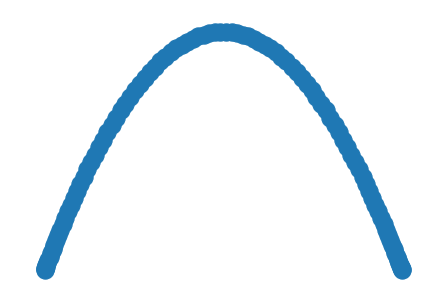

In [3]:
nx.draw_spectral(G)

# Problem Parameters

In [4]:
theta_0 = (1/(n+3))*np.ones((n,n))-np.eye(n)
theta = theta_0 + 0.1*np.random.randn(n,n)
print(theta)
xi = n

[[-0.86660595 -0.08352952  0.1501735  ... -0.11364056 -0.09051471
  -0.06750873]
 [ 0.06013543 -1.07298637  0.00628074 ...  0.10421378  0.08393931
   0.14285693]
 [ 0.19230487 -0.16281927 -0.97925593 ... -0.07882725  0.11725957
   0.0603664 ]
 ...
 [-0.03624918  0.16419193  0.01306272 ... -1.05856406  0.06525573
  -0.07260191]
 [ 0.12035869 -0.06362219  0.06688016 ...  0.16582322 -1.03292653
  -0.03113579]
 [-0.0455348  -0.06834372  0.0794236  ...  0.28056404  0.02099263
  -1.04564628]]


# Loss and Gradient Oracles

In [5]:
def demand(x,theta,xi):  # calculate demand
    return np.dot(theta,x) + xi

def revenue(x,theta,xi):  # calculate revenue
    return x*demand(x,theta,xi)

def total_revenue(x,theta,xi):  # calculate social revenue
    return np.sum(revenue(x,theta,xi))

def grad_revenue(x,theta,xi):  # gradients wrt individual revenues
    return 2*np.dot(theta,x) + xi

# Centralized GD

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 6833.89it/s]


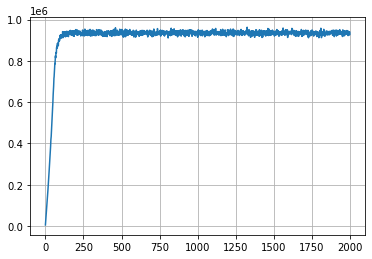

[4.79450596e+01 6.78456650e+01 1.00000000e+02 1.83505521e+01
 4.69099938e+01 1.00000000e+02 1.00000000e+02 5.24402896e+01
 6.23480988e+01 0.00000000e+00 7.61227361e+01 5.06479262e+01
 5.04268152e+01 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 2.03636931e+01
 1.00000000e+02 0.00000000e+00 1.00000000e+02 2.57362652e+01
 1.00000000e+02 1.00000000e+02 1.25207121e+01 2.32380805e-04
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 9.43437095e+01
 0.00000000e+00 5.56243853e+01 7.03869819e+01 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 3.07361374e+01
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 9.84088129e+01
 8.52952749e+01 1.00000000e+02 1.00000000e+02 0.00000000e+00
 1.00000000e+02 1.00000000e+02 1.00000000e+02 1.00000000e+02
 1.00000000e+02 1.00000000e+02 1.00000000e+02 6.47305899e+01
 1.00000000e+02 1.000000

In [6]:
x = np.random.rand(n)  # Initialize prices
step = 1e-2  # Step size
p_max = n  # Set maximum price
rev = []
x_hist = []
iterations = 2000

# Run centralized GD
for i in trange(iterations):
    xi = n+np.random.randn(1)
    rev.append(total_revenue(x,theta,xi))
    x_hist.append(x.copy())
    x += step*grad_revenue(x,theta,xi)
    x = np.clip(x,0,p_max)
    
plt.figure()
plt.plot(rev)
plt.grid()
plt.show()

print(x)

In [7]:
if n==2:
    x_hist = np.array(x_hist)
    plt.figure()
    plt.plot(x_hist[:,0],x_hist[:,1],'-o')
    plt.scatter(x_hist[-1,0],x_hist[-1,1],c='k',zorder=10)
    plt.grid()
    plt.show()

# Distributed SGD with synchronous information

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
100%|██████████████████████████████████████| 2000/2000 [00:14<00:00, 134.55it/s]


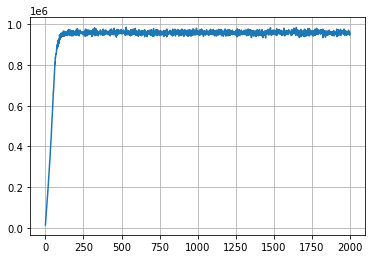

[ 47.89697475  67.82182951 100.          18.30487896  46.893055
 100.         100.          52.40558358  62.3357274    0.
  76.09198741  50.61105094  50.390564   100.         100.
 100.         100.         100.         100.          20.32681528
 100.           0.         100.          25.67976655 100.
 100.          12.50255826   0.         100.         100.
 100.         100.         100.         100.         100.
  94.32594697   0.          55.59158077  70.34157244 100.
 100.         100.         100.          30.7158277  100.
 100.         100.         100.         100.         100.
 100.          98.38016634  85.26834307 100.         100.
   0.         100.         100.         100.         100.
 100.         100.         100.          64.67858144 100.
 100.           0.          91.10660122  98.09810421   0.
 100.          44.85293889 100.         100.          26.53419247
 100.         100.          57.12429658  65.80661769 100.
   0.         100.         100.         100.      

In [8]:
P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_cent = []
x_hist = []
iterations = 2000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    x_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        X[j] += step*grad_revenue(X[j],theta,xi)
        temp.append(total_revenue(X[j],theta,xi))
    rev_cent.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_cent)
plt.grid()
plt.show()

print(np.mean(X,axis=0))

In [9]:
if n==2:
    x_hist = np.array(x_hist)
    plt.figure()
    plt.plot(x_hist[:,0],x_hist[:,1],'-o')
    plt.scatter(x_hist[-1,0],x_hist[-1,1],c='k',zorder=10)
    plt.grid()
    plt.show()

In [10]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.03210242968224426


# Distributed SGD with synchronous information

100%|██████████████████████████████████████| 2000/2000 [00:15<00:00, 127.52it/s]


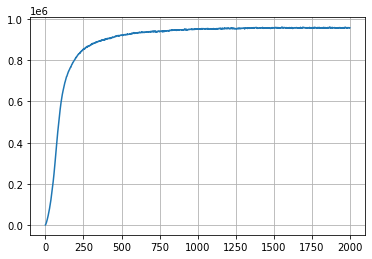

[ 47.91732989  67.81738397 100.          18.32088248  46.91190478
 100.         100.          52.44006888  62.32556176   0.
  76.09505942  50.60025313  50.40712077 100.         100.
 100.         100.         100.         100.          20.35032891
 100.           0.         100.          25.6954271  100.
 100.          12.50436987   0.         100.         100.
 100.         100.         100.         100.         100.
  94.31729823   0.          55.59763477  70.38271009 100.
 100.         100.         100.          30.72499332 100.
 100.         100.         100.         100.         100.
 100.          98.37395933  85.28106992 100.         100.
   0.         100.         100.         100.         100.
 100.         100.         100.          64.67727446 100.
 100.           0.          91.08532164  98.08602101   0.
 100.          44.85186315 100.         100.          26.54515647
 100.         100.          57.14325334  65.76351472 100.
   0.         100.         100.         100.    

In [11]:
P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_dist = []
x_dist_hist = []
iterations = 2000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    for node in range(n):
        if G.nodes[node]['informed']:
            G.nodes[node]['xi'] = xi
        else:
            xi_lst = []
            for neig in G.neighbors(node):
                xi_lst.append(G.nodes[neig]['xi'])
            G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
    x_dist_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        xi_j = G.nodes[j]['xi']
        X[j] += step*grad_revenue(X[j],theta,xi_j)
        temp.append(total_revenue(X[j],theta,xi_j))
    rev_dist.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_dist)
plt.grid()
plt.show()

print(np.mean(X,axis=0))

In [12]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.02518642274551589


# Fully connected graph

100%|██████████████████████████████████████| 2000/2000 [00:18<00:00, 105.74it/s]


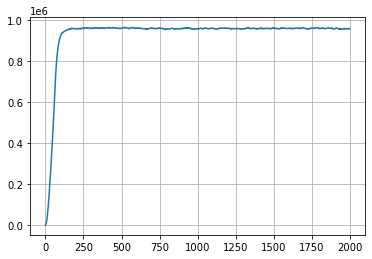

[ 47.86010635  67.77554253 100.          18.26267367  46.88079076
 100.         100.          52.39149961  62.29555665   0.
  76.04847393  50.54665908  50.35700951 100.         100.
 100.         100.         100.         100.          20.30151049
 100.           0.         100.          25.62804178 100.
 100.          12.46684807   0.         100.         100.
 100.         100.         100.         100.         100.
  94.28064243   0.          55.54737846  70.32950124 100.
 100.         100.         100.          30.68873043 100.
 100.         100.         100.         100.         100.
 100.          98.32827054  85.23963938 100.         100.
   0.         100.         100.         100.         100.
 100.         100.         100.          64.61066203 100.
 100.           0.          91.03810597  98.0319354    0.
 100.          44.80232743 100.         100.          26.50531513
 100.         100.          57.08872025  65.74190834 100.
   0.         100.         100.         100.    

In [13]:
n = 100  # Number of nodes
n_i = 5  # Number of informed nodes

N_i = np.random.choice(n, size=n_i)  # Randomly select n_i informed nodes
N = np.zeros(n, dtype=bool)  # Set of n nodes, initialized to False (uninformed)
N[N_i] = True  # Set informed node indices to True (informed)

G = nx.erdos_renyi_graph(n,0.2)  # Generate line graph from the nodes in N

attribute_dict = {}  # generate dictionary to add informed status as attribute to each node
for node in G.nodes:
    attribute_dict[node] = {'informed': N[node], 'xi': np.random.randn(1)}  
    
nx.set_node_attributes(G, attribute_dict)  # set attributes for each node

P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_dist = []
x_dist_hist = []
iterations = 2000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    for node in range(n):
        if G.nodes[node]['informed']:
            G.nodes[node]['xi'] = xi
        else:
            xi_lst = []
            for neig in G.neighbors(node):
                xi_lst.append(G.nodes[neig]['xi'])
            G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
    x_dist_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        xi_j = G.nodes[j]['xi']
        X[j] += step*grad_revenue(X[j],theta,xi_j)
        temp.append(total_revenue(X[j],theta,xi_j))
    rev_dist.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_dist)
plt.grid()
plt.show()

print(np.mean(X,axis=0))

In [14]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.16153001700298983


# Erdos Renyi random graph p=0.2

100%|███████████████████████████████████████| 2000/2000 [00:25<00:00, 79.56it/s]


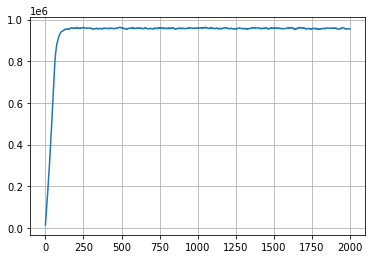

[ 47.8702611   67.76605268 100.          18.27393118  46.86746704
 100.         100.          52.3958105   62.27466954   0.
  76.04598681  50.5470061   50.36079807 100.         100.
 100.         100.         100.         100.          20.30476408
 100.           0.         100.          25.64740649 100.
 100.          12.45425425   0.         100.         100.
 100.         100.         100.         100.         100.
  94.2672873    0.          55.54591706  70.3415173  100.
 100.         100.         100.          30.67699394 100.
 100.         100.         100.         100.         100.
 100.          98.32334713  85.23451929 100.         100.
   0.         100.         100.         100.         100.
 100.         100.         100.          64.62424689 100.
 100.           0.          91.03054417  98.03198646   0.
 100.          44.80065123 100.         100.          26.49807292
 100.         100.          57.09566107  65.70634818 100.
   0.         100.         100.         100.    

In [15]:
P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_dist = []
x_dist_hist = []
iterations = 2000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    for node in range(n):
        if G.nodes[node]['informed']:
            G.nodes[node]['xi'] = xi
        else:
            xi_lst = []
            for neig in G.neighbors(node):
                xi_lst.append(G.nodes[neig]['xi'])
            G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
    x_dist_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        xi_j = G.nodes[j]['xi']
        X[j] += step*grad_revenue(X[j],theta,xi_j)
        temp.append(total_revenue(X[j],theta,xi_j))
    rev_dist.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_dist)
plt.grid()
plt.show()

print(np.mean(X,axis=0))

In [16]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.16758287695930338
